# Median filtering

One other way is to use a rolling median filter and detect significant deviations from that. The old imports and basic dataset manipulations:

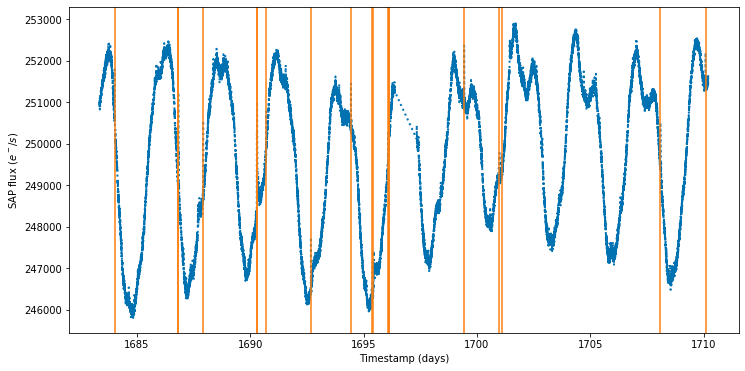

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy
from scipy import ndimage
import pandas

mp.style.use('seaborn-colorblind')

def lcplot(t,f,color="",line=":",lw=2):
    '''
    Simple lightcurve plot function
    '''
    mp.rcParams['figure.figsize'] = [12, 6]
    plt.plot(t,f,color+line,linewidth=lw)
    plt.xlabel("Timestamp (days)")
    plt.ylabel(r"SAP flux ($e^-/s$)")

def lcminiplot(t,f,axs,i,j,color="",line="."):
    axs[i,j].plot(t,f,color+line)

def slice_t_pdc(t,lc,t0,t1):
    '''
    Returns a tuple (tslice, lcslice) of the time and the lightcurve arrays
    between t0 and t1
    '''
    tslice1 = t[t < t1]
    tslice2 = tslice1[tslice1 > t0]
    lslice1 = lc[t < t1]
    lslice2 = lslice1[tslice1 > t0]
    return (tslice2,lslice2)
    
hdul = fits.open('tess2019198215352-s0014-0000000159613900-0150-s_lc.fits')
lcdata = hdul[1].data
pdcflux_raw = lcdata.field(7)
time_raw = lcdata.field(0)
has_errors = np.isnan(pdcflux_raw)
pdcflux = pdcflux_raw[~has_errors]
time = time_raw[~has_errors]

N = len(pdcflux)
jumps = np.zeros(N-1)
for i in range(1,N):
    jumps[i-1] = (pdcflux[i]-pdcflux[i-1])/(time[i]-time[i-1])

top02 = np.percentile(jumps[jumps > 0], 99.8, axis=None, out=None)
lcplot(time,pdcflux)

flare_candidates = []
for i in range(N-1):
    if jumps[i] > top02:
        flare_candidates.append([i,time[i]])
        plt.axvline(time[i],color='tab:orange')

Now I will implement a median filter of size ~100 samples (a few hours) and test for 5 or more consecutive deviations of >500 above the median.

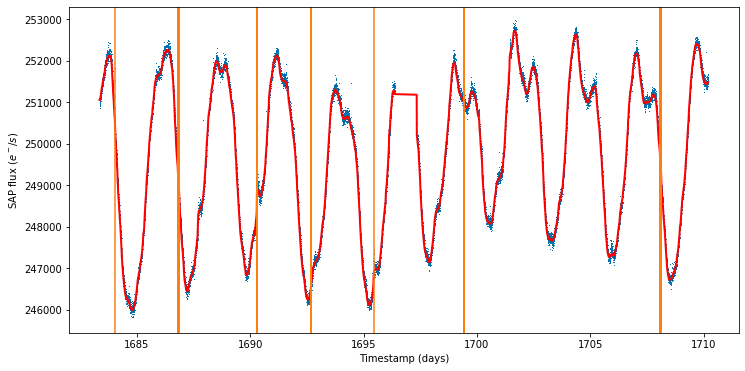

In [2]:
pdcflux_median = ndimage.median_filter(pdcflux,size=(100))
lcplot(time,pdcflux,line=",",lw=1.5)
lcplot(time,pdcflux_median,color="r",line="-",lw=2)
thrsh = 4
for i in range(len(pdcflux)):
    for j in range(thrsh):
        if pdcflux[i+j] < pdcflux_median[i+j]+300:
            break
        if j == thrsh-1:
            plt.axvline(time[i],color='tab:orange')

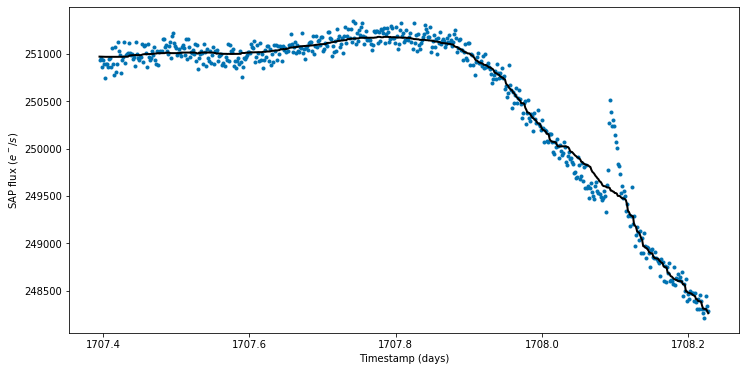

In [9]:
lcplot(time[16500:17100],pdcflux[16500:17100],line=".")
lcplot(time[16500:17100],pdcflux_median[16500:17100],color="k",line="-")